# **Character-Level GRU Language Model**

## **From Scratch Implementation in NumPy**

This notebook implements a **vanilla GRU** for character-level language modeling.


### **What We'll Build:**
- **Vanilla GRU** with two (update, reset) gates
- **Backpropagation** for gradient computation
- **Character-level text generation** from learned patterns
---
*Notebook by*: Ahmad Raza [@ahmadrazacdx](https://github.com/ahmadrazacdx)<br>
*Date: 2025*  
*License: MIT*

In [ ]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')

In [ ]:
#Load Data
data = open('../data/thirsty_crow.txt', 'r').read()
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print(f'Data has {data_size} characters, {vocab_size} unique.')

In [6]:
char_to_ix = {ch:i for i,ch in enumerate(chars)}

In [7]:
ix_to_char = {i:ch for i,ch in enumerate(chars)}

### __HYPER-PARAMETERS__

In [8]:
lr = 1e-3 # learning rate
seq_len = 25 # times GRU will be unrolled (Timesteps)
hidden_size= 100 # size of hidden units

### __MODEL PARAM INIT__
**Initializing weight matrices for the GRU.**

**Gate Weight Matrices (concatenated input $[\mathbf{h}_{t-1}; \mathbf{x}_t]$):**
- $\mathbf{W}_u \in \mathbb{R}^{H \times (H+V)}$ Update gate weights
- $\mathbf{W}_r \in \mathbb{R}^{H \times (H+V)}$ Reset gate weights
- $\mathbf{W}_h \in \mathbb{R}^{H \times (H+V)}$ Candidate hidden state weights

**Output Layer:**
- $\mathbf{W}_y \in \mathbb{R}^{V \times H}$ Hidden-to-output weights

**Biases:**
- Gate biases: $\mathbf{b}_u, \mathbf{b}_r, \mathbf{b}_h \in \mathbb{R}^{H \times 1}$
- Output bias: $\mathbf{b}_y \in \mathbb{R}^{V \times 1}$

**Total parameters:** $3H(H+V) + VH + 3H + V$

**Where:** $V$ = vocabulary size (33 unique chars), $H$ = hidden size (100)

**Note:** GRU has ~25% fewer parameters than LSTM due to simpler architecture (2 gates vs 3, single hidden state vs separate cell state).

In [9]:
Wu = np.random.randn(hidden_size, hidden_size+vocab_size)*0.01 # Update Gate weights (H, H+V)
Wr = np.random.randn(hidden_size, hidden_size+vocab_size)*0.01 # Reset Gate weights (H, H+V)
Wh = np.random.randn(hidden_size, hidden_size+vocab_size)*0.01 # Candidate Hidden State weights (H, H+V)
Wy = np.random.randn(vocab_size, hidden_size)*0.01 # Prediction weights (V, H)
bu = np.zeros((hidden_size, 1)) # Update Gate bias (H, 1)
br = np.zeros((hidden_size, 1)) # Reset Gate bias(H, 1)
bh = np.zeros((hidden_size, 1)) # CHS bias (H, 1)
by = np.zeros((vocab_size, 1)) # prediction bias (V, 1)

In [10]:
print(f"""
Wu: Update Gate Weights  : {Wu.shape}
Wr: Reset Gate Weights   : {Wr.shape}
Wh: CHS Weights          : {Wh.shape}
Wy: Prediction Weights   : {Wy.shape}
bu: Update Gate bias     : {bu.shape}
br: Reset Gate bias      : {br.shape}
bh: CHS bias             : {bh.shape}
by: Prediction bias      : {by.shape}
""")


Wu: Update Gate Weights  : (100, 133)
Wr: Reset Gate Weights   : (100, 133)
Wh: CHS Weights          : (100, 133)
Wy: Prediction Weights   : (33, 100)
bu: Update Gate bias     : (100, 1)
br: Reset Gate bias      : (100, 1)
bh: CHS bias             : (100, 1)
by: Prediction bias      : (33, 1)



### __ADAM OPTIMIZER INITIALIZATION__

In [11]:
# Adam hyperparameters
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Adam memory variables (first moment)
mWu = np.zeros_like(Wu)
mWr = np.zeros_like(Wr)
mWh = np.zeros_like(Wh)
mWy = np.zeros_like(Wy)
mbu = np.zeros_like(bu)
mbr = np.zeros_like(br)
mbh = np.zeros_like(bh)
mby = np.zeros_like(by)

# Adam memory variables (second moment)
vWu = np.zeros_like(Wu)
vWr = np.zeros_like(Wr)
vWh = np.zeros_like(Wh)
vWy = np.zeros_like(Wy)
vbu = np.zeros_like(bu)
vbr = np.zeros_like(br)
vbh = np.zeros_like(bh)
vby = np.zeros_like(by)
# Timestep counter for bias correction
t_adam = 0

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def softmax(z):
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

### __SINGLE GRU CELL__
**GRU Forward Pass Equations:**
**Note:** This implementation follows paper's (Cho et al. 2014) equations. The frameworks like PyTorch and others follow slightly different equations for efficiency.

**Update Gate:**
$$\mathbf{z}_u = \mathbf{W}_u[\mathbf{h}_{t-1}; \mathbf{x}_t] + \mathbf{b}_u$$
$$\mathbf{u}_t = \sigma(\mathbf{z}_u)$$
**Reset Gate:**
$$\mathbf{z}_r = \mathbf{W}_r[\mathbf{h}_{t-1}; \mathbf{x}_t] + \mathbf{b}_r$$
$$\mathbf{r}_t = \sigma(\mathbf{z}_r)$$
**Candidate Hidden State:**
$$\mathbf{z}_h = \mathbf{W}_h[\mathbf{r}_t \odot \mathbf{h}_{t-1}; \mathbf{x}_t] + \mathbf{b}_h$$
$$\tilde{\mathbf{h}}_t = \tanh(\mathbf{z}_h)$$
**Hidden State (Linear Interpolation):**
$$\mathbf{h}_t = (1 - \mathbf{u}_t) \odot \mathbf{h}_{t-1} + \mathbf{u}_t \odot \tilde{\mathbf{h}}_t$$
**Output:**
$$\mathbf{y}_t = \mathbf{W}_y \mathbf{h}_t + \mathbf{b}_y$$
**Where:** $\sigma$ = sigmoid, $\odot$ = element-wise multiplication

**Reference:** Cho et al. (2014) - *Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation*

In [13]:
def gru(h_prev, xt):
    zt = np.concatenate((h_prev, xt), axis=0) #(H+V,1)
    # Update Gate
    zu = np.dot(Wu, zt) + bu #(H,H+V)@(H+V,1)->(H,1)+(H,1)=(H,1)
    ut = sigmoid(zu) # (H,1)
    #Reset Gate
    zr = np.dot(Wr, zt) + br #(H,H+V)@(H+V,1)->(H,1)+(H,1)=(H,1)
    rt = sigmoid(zr) # (H,1)
    #Candidate Hidden State
    zt_h = np.concatenate((rt * h_prev, xt), axis=0) # (H,1)*(H,1)=(H,1):(V,1)= (H+V,1)
    zh = np.dot(Wh, zt_h) + bh #(H,H+V)@(H+V,1)->(H,1)+(H,1)=(H,1)
    cht = np.tanh(zh) # (H,1)
    #Hidden State
    ht = ((1-ut) * h_prev) + (ut * cht) # (H,1)+(H,1)=(H,1)
    #Output logits
    yt = np.dot(Wy, ht) + by # #(V,H)@(H,1)->(V,1)+(V,1)=(V,1)
    return ut, rt, cht, ht, yt

**Understanding the GRU Cell:**

**What's happening here?**
- At each timestep $t$, the GRU takes two inputs:
  1. Current character $\mathbf{x}_t$ (one-hot vector)
  2. Previous hidden state $\mathbf{h}_{t-1}$
  
- It outputs:
  1. New hidden state $\mathbf{h}_t$ (combines short and long-term memory)
  2. Prediction $\mathbf{y}_t$ (probability distribution)

**The GRU Magic - Two Gates:**

1. **Update gate** ($\mathbf{u}_t$): Decides how much of the past to keep vs new candidate
   - Acts like combined forget + input gate in LSTM
   - When $\mathbf{u}_t \approx 0$: Keep old hidden state (remember long-term)
   - When $\mathbf{u}_t \approx 1$: Use new candidate (incorporate new info)

2. **Reset gate** ($\mathbf{r}_t$): Decides how much past information to use when computing candidate
   - Controls access to previous hidden state
   - When $\mathbf{r}_t \approx 0$: Ignore past, compute fresh candidate
   - When $\mathbf{r}_t \approx 1$: Use full previous hidden state


### __FORWARD PASS__


In [14]:
def forward(inputs, targets, h_prev):
    """
    Forward pass through GRU Cell

    Inputs:
        - inputs: List of character indices, e.g., [5, 8, 12, 12, 15] for "hello"
        - targets: List of target character indices (inputs shifted by 1)
        - h_prev: Initial hidden state from previous sequence, shape (H, 1)

    Returns:
        - xt: Dict of one-hot inputs {0: x_0, 1: x_1, ...}
        - ht: Dict of hidden states {-1: h_init, 0: h_0, 1: h_1, ...}
        - probt: Dict of probability distributions {0: p_0, 1: p_1, ...}
        - loss: Total cross-entropy loss across all timesteps (scalar)
    """
    # Initialize storage dictionaries
    xt = {}  # Store one-hot encoded inputs
    ut = {}  # Store update gate values
    rt = {}  # Store reset gate values
    cht = {} # Store chs values
    ht = {}  # Store hidden states
    yt = {}  # Store logits
    probt = {}  # Store probability distributions (after softmax)

    # Set initial hidden and cell state
    ht[-1] = np.copy(h_prev) #(H,1)
    loss = 0
    # Loop through each timestep in the sequence
    for t in range(len(inputs)):
        # Step 1: Convert character index to one-hot vector
        xt[t] = np.zeros((vocab_size, 1)) #(V,1)
        xt[t][inputs[t]] = 1  # Set the position of char to 1, (V,1)
        # Step 2: Run GRU cell (forward computation)
        ut[t], rt[t], cht[t], ht[t], yt[t] = gru(ht[t-1], xt[t])
        # Step 3: Apply softmax
        probt[t] = softmax(yt[t])
        # Step 3: Compute loss for this timestep
        # Cross-entropy: -log(probability of correct next character)
        loss += -np.log(probt[t][targets[t], 0]+ epsilon)

    cache = (h_prev, ut, rt, cht)
    return xt, ht, probt, loss, cache

### __BACKWARD PASS (BPTT)__
**Complete GRU Backpropagation Through Time Equations**

#### **Step 1: Output Layer Gradient (Softmax + Cross-Entropy)**

$$\frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} = \mathbf{p}_t - \mathbf{1}_{y^*_t}$$

Where $\mathbf{p}_t$ is the predicted probability distribution and $\mathbf{1}_{y^*_t}$ is the one-hot vector of the true label.

**Output layer weight gradients:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_y} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} \mathbf{h}_t^T$$

$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_y} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t}$$

#### **Step 2: Hidden State Gradient**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} = \mathbf{W}_y^T \frac{\partial \mathcal{L}_t}{\partial \mathbf{y}_t} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t+1}}$$

The gradient flows from two sources:
- Current timestep's output loss (first term)
- Future timestep's hidden state (second term, initialized as zeros for the last timestep)

#### **Step 3: Candidate Hidden State Gradients**

Recall: $\mathbf{h}_t = (1 - \mathbf{u}_t) \odot \mathbf{h}_{t-1} + \mathbf{u}_t \odot \tilde{\mathbf{h}}_t$

**Gradient w.r.t. candidate hidden state (after tanh):**
$$\frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{h}}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot \mathbf{u}_t$$

**Key Insight:** Only the portion gated by $\mathbf{u}_t$ contributes to $\tilde{\mathbf{h}}_t$.

**Gradient w.r.t. candidate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} = \frac{\partial \mathcal{L}}{\partial \tilde{\mathbf{h}}_t} \odot (1 - \tilde{\mathbf{h}}_t^2)$$

(Using tanh derivative: $\tanh'(z) = 1 - \tanh^2(z)$)

#### **Step 4: Update Gate Gradients**

Recall: $\mathbf{h}_t = (1 - \mathbf{u}_t) \odot \mathbf{h}_{t-1} + \mathbf{u}_t \odot \tilde{\mathbf{h}}_t$

**Gradient w.r.t. update gate (after sigmoid):**

Taking the derivative:
$$\frac{\partial \mathbf{h}_t}{\partial \mathbf{u}_t} = -\mathbf{h}_{t-1} + \tilde{\mathbf{h}}_t = \tilde{\mathbf{h}}_t - \mathbf{h}_{t-1}$$

Therefore:
$$\frac{\partial \mathcal{L}}{\partial \mathbf{u}_t} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot (\tilde{\mathbf{h}}_t - \mathbf{h}_{t-1})$$

**Gradient w.r.t. update gate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_u} = \frac{\partial \mathcal{L}}{\partial \mathbf{u}_t} \odot \mathbf{u}_t \odot (1 - \mathbf{u}_t)$$

(Using sigmoid derivative: $\sigma'(z) = \sigma(z)(1-\sigma(z))$)

#### **Step 5: Reset Gate Gradients**

Recall: $\tilde{\mathbf{h}}_t = \tanh(\mathbf{W}_h[\mathbf{r}_t \odot \mathbf{h}_{t-1}; \mathbf{x}_t] + \mathbf{b}_h)$

The reset gate affects the candidate computation through the concatenated input.

**Gradient w.r.t. concatenated input for candidate:**
$$\frac{\partial \mathcal{L}}{\partial [\mathbf{r}_t \odot \mathbf{h}_{t-1}; \mathbf{x}_t]} = \mathbf{W}_h^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h}$$

**Extract gradient for reset-gated hidden state (first $H$ elements):**
$$\frac{\partial \mathcal{L}}{\partial (\mathbf{r}_t \odot \mathbf{h}_{t-1})} = \left[\mathbf{W}_h^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h}\right]_{[0:H]}$$

**Gradient w.r.t. reset gate (after sigmoid):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{r}_t} = \frac{\partial \mathcal{L}}{\partial (\mathbf{r}_t \odot \mathbf{h}_{t-1})} \odot \mathbf{h}_{t-1}$$

**Gradient w.r.t. reset gate pre-activation:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{z}_r} = \frac{\partial \mathcal{L}}{\partial \mathbf{r}_t} \odot \mathbf{r}_t \odot (1 - \mathbf{r}_t)$$

#### **Step 6: Weight Matrix Gradients (All Gates)**

For update gate, reset gate, and candidate computation:

**Update Gate:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_u} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u} [\mathbf{h}_{t-1}; \mathbf{x}_t]^T$$
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_u} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u}$$

**Reset Gate:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_r} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r} [\mathbf{h}_{t-1}; \mathbf{x}_t]^T$$
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_r} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r}$$

**Candidate Hidden State:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{W}_h} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h} [\mathbf{r}_t \odot \mathbf{h}_{t-1}; \mathbf{x}_t]^T$$
$$\frac{\partial \mathcal{L}}{\partial \mathbf{b}_h} = \sum_{t=0}^{T-1} \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h}$$

#### **Step 7: Gradient to Previous Hidden State**

The gradient $\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}$ flows through **four pathways**:

**1. Through Update Gate Input:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(u)} = \left[\mathbf{W}_u^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u}\right]_{[0:H]}$$

**2. Through Reset Gate Input:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(r)} = \left[\mathbf{W}_r^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r}\right]_{[0:H]}$$

**3. Through Candidate Computation (gated by reset):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(h)} = \left[\mathbf{W}_h^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h}\right]_{[0:H]} \odot \mathbf{r}_t$$

**4. Direct path through hidden state update:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(\text{direct})} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot (1 - \mathbf{u}_t)$$

**Total gradient to previous hidden state:**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(u)} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(r)} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(h)} + \frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(\text{direct})}$$

**Key Insight:** The direct pathway $(1 - \mathbf{u}_t) \odot \mathbf{h}_{t-1}$ allows gradients to flow unimpeded when the update gate is closed ($\mathbf{u}_t \approx 0$), mitigating vanishing gradients!

#### **Step 8: Gradient Clipping**

To prevent exploding gradients, clip all parameter gradients:

$$\text{clip}(\nabla \theta, -\tau, \tau)$$

Common clipping threshold: $\tau = 5$

**Notation:**
- $\odot$ = element-wise multiplication
- $\sigma$ = sigmoid function
- $T$ = sequence length
- $H$ = hidden dimension
- $V$ = vocabulary size
- $[\cdot; \cdot]$ = concatenation along dimension 0

In [15]:
def backward(inputs, targets, xt, ht, probt, cache):
    """
    Backpropagation Through Time (BPTT) for GRU

    Inputs:
        - inputs: List of input character indices
        - targets: List of target character indices
        - xt: Dict of one-hot inputs from forward pass
        - ht: Dict of hidden states from forward pass
        - probt: Dict of probability distributions from forward pass
        - cache: Tuple (h_prev, ut, rt, cht) from forward pass

    Returns:
        - dWu, dWr, dWh: Gradients for gate weight matrices
        - dWy: Gradient w.r.t. hidden-to-output weights
        - dbu, dbr, dbh: Gradients for gate biases
        - dby: Gradient w.r.t. output bias
    """
    h_prev, ut, rt, cht = cache
    dWu = np.zeros_like(Wu)  # (H, H+V)
    dWr = np.zeros_like(Wr)  # (H, H+V)
    dWh = np.zeros_like(Wh)  # (H, H+V)
    dWy = np.zeros_like(Wy)  # (V, H)

    dbu = np.zeros_like(bu)  # (H, 1)
    dbr = np.zeros_like(br)  # (H, 1)
    dbh = np.zeros_like(bh)  # (H, 1)
    dby = np.zeros_like(by)  # (V, 1)

    # Gradient of hidden state at next timestep (initially zero)
    dh_next = np.zeros_like(ht[0])  # (H, 1)

    # Backpropagate through time (from last to first timestep)
    for t in reversed(range(len(inputs))):
        # Step 1: Gradient of loss w.r.t output probabilities
        dy = np.copy(probt[t])  # (V, 1)
        dy[targets[t]] -= 1  # Subtract 1 from correct class (cross-entropy gradient)

        # Step 2: Gradients for output layer
        dWy += np.dot(dy, ht[t].T)  # (V,1)@(1,H) = (V,H)
        dby += dy  # (V, 1)

        # Step 3: Gradient w.r.t hidden state
        # Comes from two sources: current output and next timestep
        dh = np.dot(Wy.T, dy) + dh_next  # (H,V)@(V,1) + (H,1) = (H,1)

        # Step 4: Gradient w.r.t candidate hidden state
        dcht = dh * ut[t]  # (H,1) * (H,1) = (H,1)
        dzh = dcht * (1 - cht[t]**2)  # (H,1)


        # Step 5: Gradient w.r.t update gate
        du = dh * (cht[t] - ht[t-1])  # (H,1) * (H,1) = (H,1)
        dzu = du * ut[t] * (1 - ut[t])  # (H,1)

        # Step 6: Gradient w.r.t reset gate
        dzt_h = np.dot(Wh.T, dzh)  # (H+V,H)@(H,1) = (H+V,1)
        dr_times_hprev = dzt_h[:hidden_size, :]  # First H elements: (H,1)
        dr = dr_times_hprev * ht[t-1]  # (H,1) * (H,1) = (H,1)
        dzr = dr * rt[t] * (1 - rt[t])  # (H,1)

        # Step 7: Create concatenated inputs for gradient computation
        zt = np.concatenate((ht[t-1], xt[t]), axis=0)  # (H+V, 1)
        zt_h = np.concatenate((rt[t] * ht[t-1], xt[t]), axis=0)  # (H+V, 1)

        # Step 8: Gradients for weight matrices and biases
        dWu += np.dot(dzu, zt.T)  # (H,1)@(1,H+V) = (H,H+V)
        dbu += dzu  # (H,1)

        dWr += np.dot(dzr, zt.T)  # (H,1)@(1,H+V) = (H,H+V)
        dbr += dzr  # (H,1)

        dWh += np.dot(dzh, zt_h.T)  # (H,1)@(1,H+V) = (H,H+V)
        dbh += dzh  # (H,1)

        # Step 9: Gradient w.r.t previous hidden state computation
        dh_from_zu = np.dot(Wu.T, dzu)[:hidden_size, :]  # (H+V,H)@(H,1)->(H+V,1)->(H,1)
        dh_from_zr = np.dot(Wr.T, dzr)[:hidden_size, :]  # (H,1)
        dh_from_zh = np.dot(Wh.T, dzh)[:hidden_size, :] * rt[t]  # (H,1) * (H,1)
        dh_from_ht = dh * (1 - ut[t])  # from ht = (1-ut)*h_prev + ut*cht

        dh_next = dh_from_zu + dh_from_zr + dh_from_zh + dh_from_ht  # (H,1)

    for dparam in [dWu, dWr, dWh, dWy, dbu, dbr, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)

    return dWu, dWr, dWh, dWy, dbu, dbr, dbh, dby

**Understanding GRU BPTT: The Gradient Flow**

**1. The Softmax-CrossEntropy Gradient**

$$\frac{\partial \mathcal{L}}{\partial \mathbf{y}} = \mathbf{p} - \mathbf{1}_{y^*}$$

**2. GRU Gradient Flow - Four Pathways**

Unlike vanilla RNNs, GRU gradients flow through **FOUR paths** to previous hidden state:

**Path 1 (Update Gate Input):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(u)} = \left[\mathbf{W}_u^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_u}\right]_{[0:H]}$$

**Path 2 (Reset Gate Input):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(r)} = \left[\mathbf{W}_r^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_r}\right]_{[0:H]}$$

**Path 3 (Candidate Computation - Gated by Reset):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(h)} = \left[\mathbf{W}_h^T \frac{\partial \mathcal{L}}{\partial \mathbf{z}_h}\right]_{[0:H]} \odot \mathbf{r}_t$$

**Path 4 (Direct Highway):**
$$\frac{\partial \mathcal{L}}{\partial \mathbf{h}_{t-1}}^{(\text{direct})} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}_t} \odot (1 - \mathbf{u}_t)$$

**The Magic of Path 4:**
- **Only element-wise multiplication** by $(1-\mathbf{u}_t)$!
- If $\mathbf{u}_t \approx 0$, gradients flow unimpeded (gradient = 1)
- This is GRU's "shortcut connection" - similar to LSTM's cell state highway!

**3. Why GRU Solves Vanishing Gradients**

**Vanilla RNN:**
$$\frac{\partial \mathbf{h}_0}{\partial \mathbf{h}_T} = \prod_{t=1}^{T} \mathbf{W}_{hh}^T \cdot \text{diag}(1-\mathbf{h}_t^2)$$
- Product of many matrices → exponential decay

**GRU Direct Path:**
$$\frac{\partial \mathbf{h}_0}{\partial \mathbf{h}_T}^{(\text{direct})} = \prod_{t=1}^{T} (1 - \mathbf{u}_t)$$
- Only element-wise products → gradients can flow for 100+ timesteps!

### __UPDATE PARAMS WITH ADAM__

In [16]:
def update_parameters(dWu, dWr, dWh, dWy, dbu, dbr, dbh, dby, learning_rate):
    """
    Update GRU model parameters using Adam optimizer with bias correction

    Inputs:
        - dWu: Gradient for Update gate weights (H, H+V)
        - dWr: Gradient for Reset gate weights (H, H+V)
        - dWh: Gradient for cell Hidden weights (H, H+V)
        - dWy: Gradient for prediction weights (V, H)
        - dbu, dbr, dbh: Gradients for gate biases (H, 1)
        - dby: Gradient for output bias (V, 1)
        - learning_rate: Step size for parameter updates

    Returns:
        - None (updates global parameters in-place)
    """
    global Wu, Wr, Wh, Wy, bu, br, bh, by
    global mWu, mWr, mWh, mWy, mbu, mbr, mbh, mby
    global vWu, vWr, vWh, vWy, vbu, vbr, vbh, vby
    global t_adam

    t_adam += 1
    params = [
        (Wu, dWu, mWu, vWu),
        (Wr, dWr, mWr, vWr),
        (Wh, dWh, mWh, vWh),
        (Wy, dWy, mWy, vWy),
        (bu, dbu, mbu, vbu),
        (br, dbr, mbr, vbr),
        (bh, dbh, mbh, vbh),
        (by, dby, mby, vby)
    ]
    updated = []
    for param, grad, m, v in params:
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        # Bias correction
        m_corrected = m / (1 - beta1 ** t_adam)
        v_corrected = v / (1 - beta2 ** t_adam)
        param = param - learning_rate * m_corrected / (np.sqrt(v_corrected) + epsilon)
        updated.append((param, m, v))

    (Wu, mWu, vWu), (Wr, mWr, vWr), (Wh, mWh, vWh), (Wy, mWy, vWy),\
    (bu, mbu, vbu), (br, mbr, vbr), (bh, mbh, vbh), (by, mby, vby) = updated

### __TRAIN MODEL__


In [17]:
def train(data, num_iterations=1000, print_every=100, sample_every=100):
    """
    Train GRU language model

    Inputs:
        - data: String of training text
        - num_iterations: Number of training iterations (not full data passes)
        - print_every: Print loss every N iterations
        - sample_every: Generate sample text every N iterations

    Returns:
        - smooth_loss: Exponentially smoothed loss value

    Note: Hidden state h_prev is maintained across sequences for temporal
        continuity. Only reset when reaching end of data or on first iteration.
    """
    smooth_loss = -np.log(1.0 / vocab_size) * seq_len
    losses =  []
    n = 0  # Iterations counter
    p = 0  # Data pointer (position in text)
    h_prev = np.zeros((hidden_size, 1))

    while n < num_iterations:
        # Reset pointer, hidden state, AND cell state at end of data or first iteration
        if p + seq_len + 1 >= len(data) or n == 0:
            h_prev = np.zeros((hidden_size, 1))  # Fresh start
            p = 0  # Go back to beginning

        # Input:  characters at positions [p, p+1, ..., p+seq_len-1]
        # Target: characters at positions [p+1, p+2, ..., p+seq_len]
        inputs = [char_to_ix[ch] for ch in data[p:p+seq_len]]
        targets = [char_to_ix[ch] for ch in data[p+1:p+seq_len+1]]
        # Forward pass
        xt, ht, probt, loss, cache = forward(inputs, targets, h_prev)
        # Update hidden state for next sequence
        h_prev = np.copy(ht[len(inputs) - 1])
        # Backward pass
        dWu, dWr, dWh, dWy, dbu, dbr, dbh, dby = backward(inputs, targets, xt, ht, probt, cache)
        # Update parameters
        update_parameters(dWu, dWr, dWh, dWy, dbu, dbr, dbh, dby, lr)
        # Update smooth loss
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        losses.append(smooth_loss)
        # Print progress
        if n % print_every == 0:
            print(f"Iter {n:6d} | Loss: {smooth_loss:.4f}")
        # Generate sample text
        if n % sample_every == 0 and n > 0:
            print(f"\n{'='*60}")
            print(f"SAMPLE at iteration {n}:")
            print(f"{'='*60}")
            sample_text = sample(data[0], n_chars=200)
            print(sample_text)
            print(f"{'='*60}\n")
        p += seq_len
        n += 1

    print("\nTraining complete!")
    return smooth_loss, losses

**Training Deep Dive: What's Really Happening?**

**The GRU Training Loop Flow:**

```
Initialize: h = zeros(100, 1)
Iteration 1:
Data: "Once upon a time, on a ve"
    → Forward: Get loss, store ALL states (h, u_t, r_t, cht)
    → h_prev = h[24]  ← Keep hidden state for next iteration!
    → Backward: Compute gradients for 8 parameters (Wu, Wr, Wh, Wy, bu, br, bh, by)
    → Adam: Update all parameters
Iteration 2:
Data: "ry hot day, a thirsty cro"
    → Forward with h_prev from iteration 1  ← STATE CONTINUITY!
    → ...
```

**Why GRU Training Works:**

1. **Single state continuity**: `h_prev` maintained across sequences (simpler than LSTM's dual state)
2. **Direct gradient highway**: $(1-\mathbf{u}_t)$ path enables learning dependencies 100+ timesteps away
3. **Adaptive gating**: Update gate decides keep vs update; reset gate controls candidate computation
4. **Efficient computation**: 25% fewer parameters than LSTM, faster forward/backward passes
5. **Comparable performance**: Empirically matches LSTM on most tasks despite simpler architecture

**Critical for GRU:** Must maintain `h_prev` across sequences. Resetting breaks temporal continuity and long-term learning!

### __SAMPLING FUNCTION (GENERATE TEXT)__

In [18]:
def sample(seed_char, n_chars=100):
    """
    Generate text by sampling from the trained GRU language model

    Inputs:
        - seed_char: Starting character for text generation
        - n_chars: Number of characters to generate (default 100)

    Returns:
        - String of generated text starting with seed_char

    Note: Uses stochastic sampling from probability distribution (not argmax).
        GRU uses only hidden state h (no cell state needed).
    """
    if seed_char not in char_to_ix:
        if seed_char.lower() in char_to_ix:
            seed_char = seed_char.lower()
        else:
            seed_char = data[0]
            print(f"Warning: Seed not in vocab. Using '{seed_char}' instead")

    x = np.zeros((vocab_size, 1)) # Convert seed character to one-hot
    x[char_to_ix[seed_char]] = 1
    h = np.zeros((hidden_size, 1)) # Initialize hidden state
    generated_chars = [seed_char] # Store generated characters

    for _ in range(n_chars):
        _, _, _, h, y = gru(h, x)
        p = softmax(y)
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        char = ix_to_char[ix]
        generated_chars.append(char)
        x = np.zeros((vocab_size, 1))
        x[ix] = 1

    return ''.join(generated_chars)

### __RUN TRAINING__

In [19]:
_, loss = train(data, num_iterations=10000, print_every=500, sample_every=1000)

Iter      0 | Loss: 87.4127
Iter    500 | Loss: 80.8953
Iter   1000 | Loss: 68.8993

SAMPLE at iteration 1000:
Othe, ntitk..THe Thma!H the troup The pitey ingot he wat ar fole yiwle ther inle, fot row doy,als totel cimend thel. SoiiknS Aledr muas.eh ant yimk linker wate !iqmveitg wator tiikgh fnew an he ahe she

Iter   1500 | Loss: 54.6856
Iter   2000 | Loss: 40.7877

SAMPLE at iteration 2000:
Opthe crow was feea tiye, and stintil cringh  pont. chow thorght dot anling the pioc, a vere bywan ar a tireig.
The soor intos the water.
He uldine. Then ed atly piokly flewndad on a ver. Thins uig sea

Iter   2500 | Loss: 28.5968
Iter   3000 | Loss: 19.2507

SAMPLE at iteration 3000:
Ong ur idea!

He was ane yeach it.

The criwly low was feeling tired and ftly naw a thom, tid hear ther ant meghad one ap hig ferw a bomtil ided fllwl ines into therted anued dropping bnga waten an tre

Iter   3500 | Loss: 13.2632
Iter   4000 | Loss: 8.5683

SAMPLE at iteration 4000:
Ong w ar w on ary hag das hew oo

### __PLOT LOSS CURVE__

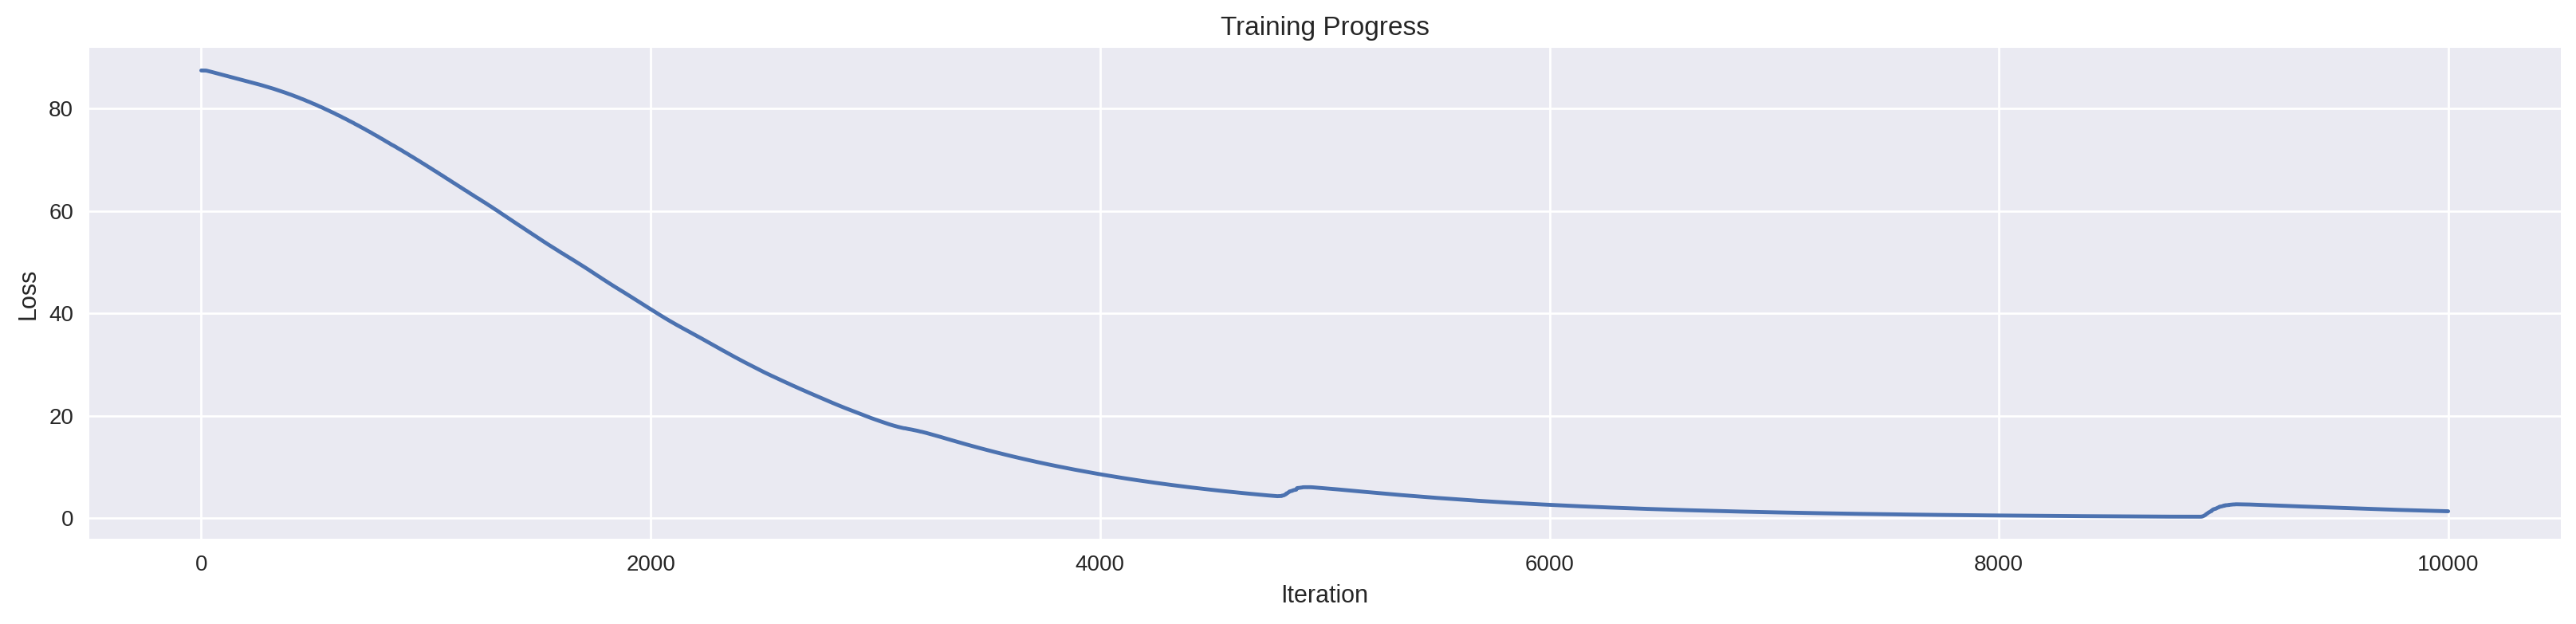

In [20]:
plt.figure(figsize=(20, 4))
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.show()

### __TEST DIFFERENT SEEDS__

In [21]:
seed_chars = ['T', 'A', 'H', 'W', 'I']
for char in seed_chars:
    generated = sample(char, n_chars=150)
    print(char, ':', generated)
    print("-" * 60)

T : The water began to rise. The crow continued dropping weared into  he sun was shining brightly, and the pior was flying in search of water. The sun was 
------------------------------------------------------------
A : Aw w a wase. The crow continued dropping stones until the water came up high enough.

At last, the crow could drink the water.
He felt refreshed and fl
------------------------------------------------------------
H : He was a little water came up high enough.

At last, the crow could drink the water.
He felt refreshed and flew away happily hot daw and the poor crow 
------------------------------------------------------------
W : wat f ung nit beak doul sha tim , srar he water begtreshof ang the poor crow was feeling tired and weak.

After flying fortiryed and flew away happily 
------------------------------------------------------------
I : ing stones until the water came up hish enough.

At latt, the poor crow was feeling tired and weak.

After flying for a long tim

## **SUMMARY**

### **Key Takeaways:**
1. **Single Hidden State**: GRUs use a single hidden state $\mathbf{h}_t$ that combines short and long-term memory (unlike LSTM's separate $\mathbf{c}_t$ and $\mathbf{h}_t$)
2. **Two-Gate Mechanism**: Update and reset gates control information flow efficiently
3. **Direct Gradient Highway**: $(1-\mathbf{u}_t)$ path solves vanishing gradients, enabling learning across 100+ timesteps
4. **Parameter Efficiency**: ~25% fewer parameters than LSTM with comparable performance
5. **Gradient Clipping Essential**: Clipping to [-5, 5] prevents exploding gradients during BPTT
6. **State Continuity Matters**: Maintaining $\mathbf{h}_t$ across sequences enables long-range learning


### **Implementation Highlights:**
- **43,533 Parameters**: 3 weight matrices (update, reset, candidate) + prediction layer
- **Character-Level Modeling**: One-hot encoding with vocab_size=33
- **Sequence Length**: 25 timesteps per training batch
- **Hidden Size**: 100 units for memory capacity
- **Training Strategy**: Exponential smoothing (0.999) for stable loss monitoring
- **Adam Optimizer**: Adaptive learning rates with momentum for each parameter

### **GRU vs LSTM Comparison:**

| Aspect | GRU | LSTM |
|--------|-----|------|
| **Gates** | 2 (update, reset) | 3 (forget, input, output) |
| **Memory** | Single $\mathbf{h}_t$ | Dual $\mathbf{c}_t$ and $\mathbf{h}_t$ |
| **Parameters** | ~43K (25% fewer) | ~57K |
| **Computation** | Faster (fewer ops) | Slower (more gates) |
| **Gradient Highway** | $(1-\mathbf{u}_t)$ on hidden | $\mathbf{f}_t$ on cell state |
| **Performance** | Comparable on most tasks | Slightly better on very long sequences |
| **Use Case** | General purpose, resource-constrained | Maximum expressiveness needed |

### **References:**
1. Cho, K., et al. (2014). *Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation*. EMNLP. [**Original GRU Paper**]
2. Chung, J., et al. (2014). *Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling*. arXiv:1412.3555.
3. Hochreiter, S., & Schmidhuber, J. (1997). *Long Short-Term Memory*. Neural Computation.

### **Further Reading:**
1. [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) — Olah (2015) - Visual explanations (covers GRU too)
2. [Empirical Evaluation of Gated RNNs](https://arxiv.org/abs/1412.3555) — Chung et al. (2014) - GRU vs LSTM comparison
3. [The Unreasonable Effectiveness of RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) — Karpathy (2015) - Character-level modeling
4. [Attention Is All You Need](https://arxiv.org/abs/1706.03762) — Vaswani et al. (2017) - Transformers replacing RNNs
5. Deep Learning Book, Chapter 10 — Goodfellow et al. (2016) - Comprehensive RNN theory
6. [GRU vs LSTM: A Comparison](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) — Practical guide with visualizations
